Train/Test data and run Poisson Regression on it before fine tuning model.

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_poisson_deviance

# Load data
sdd_df = pd.read_csv("species_distribution_data.csv")

In [77]:
infile = 'species_distribution_data.csv'

#end teh cell by visualizing teh data variable, if that is what you called it, axampe:
sdd_df.head()

,Transect,Biomass_g,MAD_mm,Length_mm,Angle_degree,Abundance,Latitude,Longitude,Management,Aspect,...,Profile_curvature,Proximity_index,Diversity,Sin_aspect,Slope,Slope_240,Slope_of_slope,Slope_of_slope_240,Wave_power,Site
0,PUP001,38.822840,628.600075,182.877062,13.639938,32,21.64489,-158.06639,1,1.625240,...,0.042634,0.000000,0.000000,-0.975315,6.09320,24.146000,21.80130,63.278702,14853.09961,PUP
1,PUP004,0.128699,292.160633,71.656667,10.811333,3,21.64273,-158.06592,1,0.766820,...,0.108896,0.000000,0.392213,-0.891849,4.09235,20.038700,12.58540,56.340500,14051.79980,PUP
2,PUP005,6.621155,517.647220,189.868200,17.229000,10,21.64514,-158.06548,1,0.558452,...,0.127880,0.000000,0.000000,-0.962263,3.14368,22.268801,9.83043,60.569500,14850.79980,PUP
3,PUP006,42.078543,927.395400,885.899000,17.002000,1,21.64744,-158.06490,1,1.464790,...,0.006456,0.124439,0.337360,-0.602419,3.51514,24.670900,12.88270,64.306198,15294.09961,PUP
4,PUP007,3.439379,675.913164,158.448636,16.340727,11,21.64641,-158.06582,1,0.818221,...,0.265389,0.361313,0.477289,-0.746824,4.10014,24.321699,14.21770,63.686298,15186.20020,PUP


In [83]:

#import the species distribution data file, then get columns I want for the training
Poisson_file = sdd_df
X = Poisson_file[['Bathymetry','Management','CCA_cover','Macroalgae_cover','Coral_cover','Turf_cover','Latitude','Longitude']]
Y = Poisson_file['Abundance']
print(np.shape(X))
print(np.shape(Y))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split data set to train/test 20/80 split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

(120, 8)
(120,)


In [84]:
model = PoissonRegressor(alpha=0.0, max_iter=500)
model.fit(X_train, Y_train)

,alpha,0.0
,fit_intercept,True
,solver,'lbfgs'
,max_iter,500
,tol,0.0001
,warm_start,False
,verbose,0


In [85]:
y_pred = model.predict(X_test)

deviance = mean_poisson_deviance(Y_test, y_pred)
print("Mean Poisson Deviance:", deviance)

Mean Poisson Deviance: 9.028438650441025


In [86]:
coef_df = pd.DataFrame({
    "Predictor": X.columns,
    "Coefficient": model.coef_,
    "Exp(Coefficient)": np.exp(model.coef_)  # multiplicative effect
})

print(coef_df)

          Predictor  Coefficient  Exp(Coefficient)
0        Bathymetry     0.004769      1.004780e+00
1        Management     0.301571      1.351982e+00
2         CCA_cover     0.014010      1.014109e+00
3  Macroalgae_cover    -0.007635      9.923940e-01
4       Coral_cover    -0.002229      9.977740e-01
5        Turf_cover    -0.007345      9.926816e-01
6          Latitude    26.429918      3.008620e+11
7         Longitude    25.152197      8.384175e+10


In [87]:
sdd_df["predicted_abundance"] = model.predict(scaler.transform(X))

c:\Users\dassoc\.conda\envs\sklearn-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PoissonRegressor was fitted with feature names
  warnings.warn(
c:\Users\dassoc\.conda\envs\sklearn-env\Lib\site-packages\sklearn\_loss\link.py:178: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)


copilot graphs

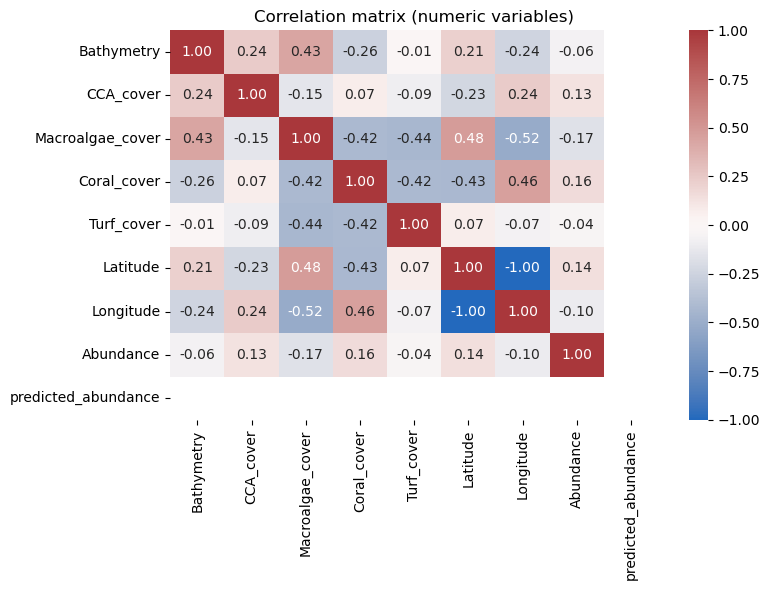

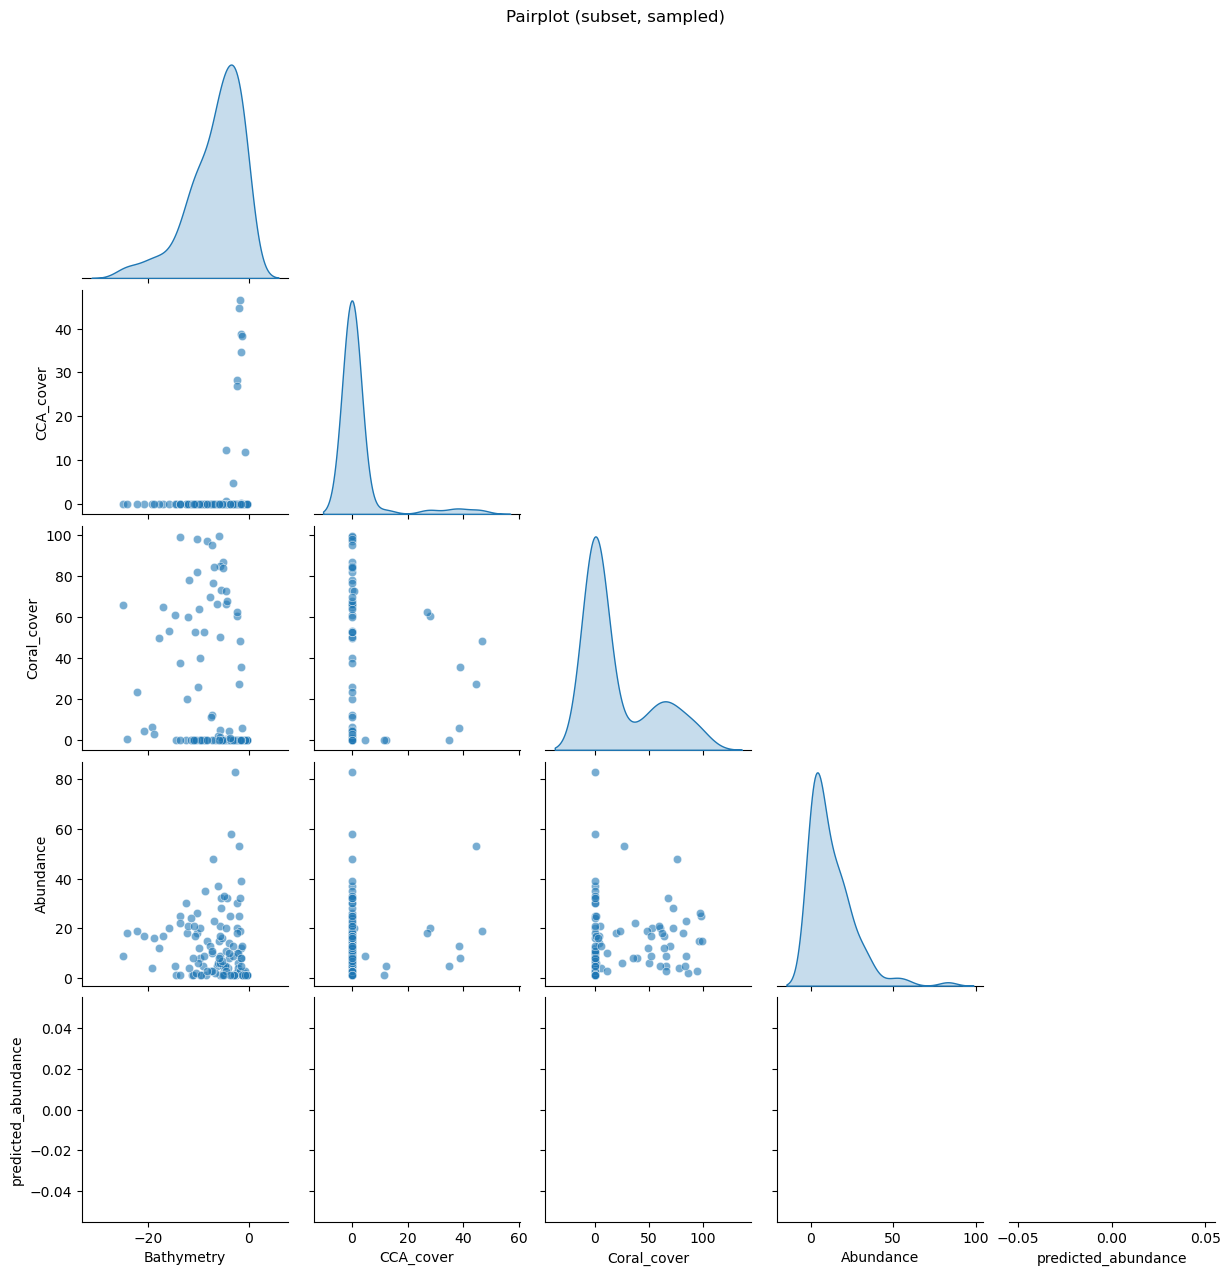

C:\Users\dassoc\AppData\Local\Temp\ipykernel_19184\3513080325.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x="Exp(Coefficient)", y="Predictor", palette="crest")


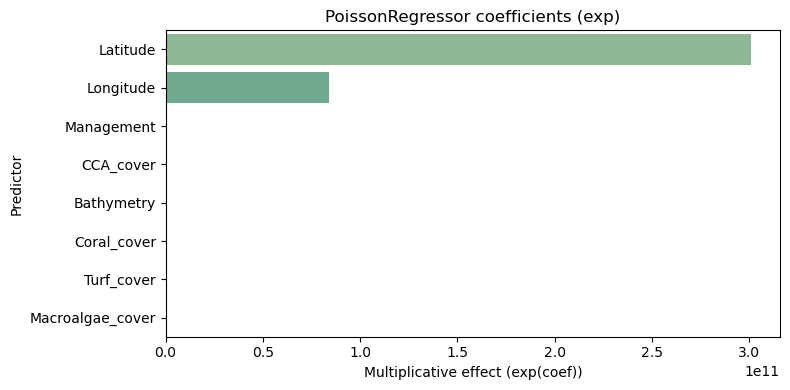

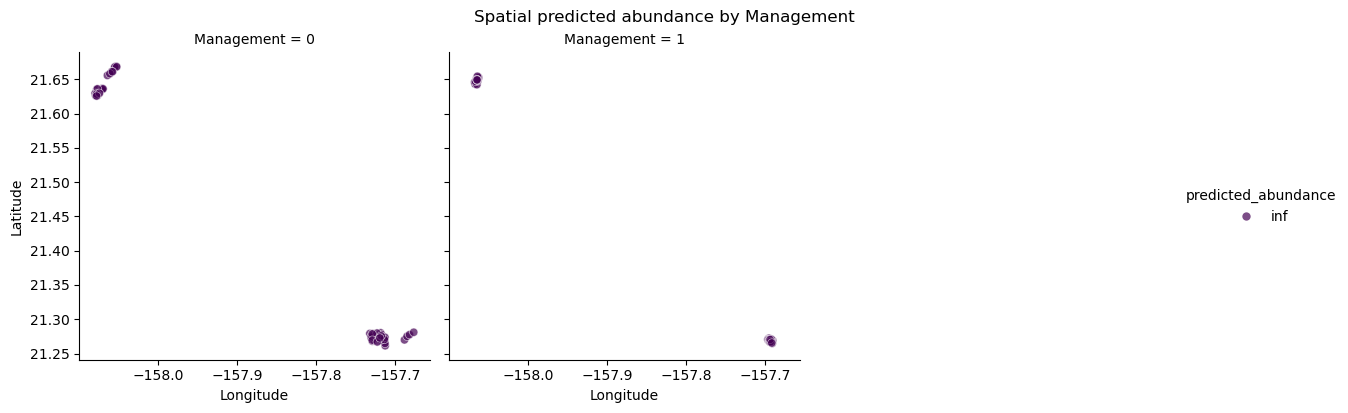

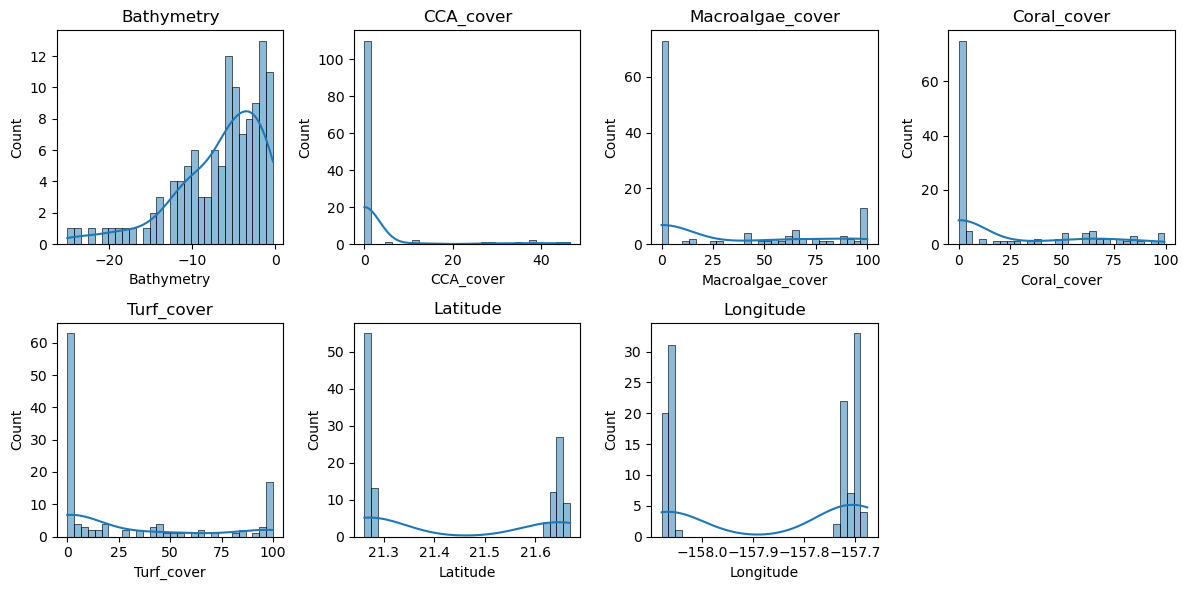

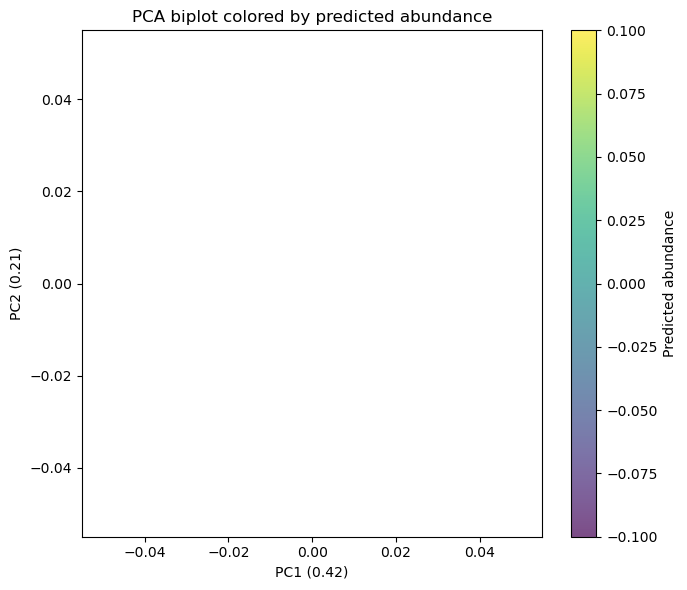

In [94]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use a sample for expensive plots
df = sdd_df.copy()
sample_n = min(2000, len(df))
df_sample = df.sample(sample_n, random_state=1)

# Numeric columns to include (adjust if your column names differ)
num_cols = [c for c in ['Bathymetry','CCA_cover','Macroalgae_cover','Coral_cover','Turf_cover',
                        'Latitude','Longitude','Abundance','predicted_abundance'] if c in df.columns]

# 1) Correlation heatmap (numeric variables)
plt.figure(figsize=(8,6))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", vmin=-1, vmax=1)
plt.title("Correlation matrix (numeric variables)")
plt.tight_layout()
plt.show()

# 2) Pairplot of numeric variables (sampled)
if len(num_cols) <= 6:
    sns.pairplot(df_sample[num_cols], corner=True, diag_kind="kde", plot_kws=dict(alpha=0.6))
    plt.suptitle("Pairplot (sampled)", y=1.02)
    plt.show()
else:
    # if many vars, plot a subset plus Abundance/predicted
    subset = [c for c in num_cols if c in ['Bathymetry','CCA_cover','Coral_cover','predicted_abundance','Abundance']]
    sns.pairplot(df_sample[subset], corner=True, diag_kind="kde", plot_kws=dict(alpha=0.6))
    plt.suptitle("Pairplot (subset, sampled)", y=1.02)
    plt.show()

# 3) Coefficients bar chart (effects on predicted count)
if hasattr(model, "coef_") and 'predicted_abundance' in df.columns:
    coef_df = pd.DataFrame({
        "Predictor": X.columns,
        "Coefficient": model.coef_,
        "Exp(Coefficient)": np.exp(model.coef_)
    }).sort_values("Exp(Coefficient)", ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(data=coef_df, x="Exp(Coefficient)", y="Predictor", palette="crest")
    plt.xlabel("Multiplicative effect (exp(coef))")
    plt.title("PoissonRegressor coefficients (exp)")
    plt.tight_layout()
    plt.show()

# 4) Spatial scatter colored by predicted abundance (faceted by Management if present)
if {'Latitude','Longitude','predicted_abundance'}.issubset(df.columns):
    if 'Management' in df.columns and df['Management'].nunique() <= 6:
        sns.relplot(data=df, x="Longitude", y="Latitude", hue="predicted_abundance",
                    col="Management", col_wrap=3, kind="scatter", palette="viridis",
                    height=4, aspect=1, alpha=0.7)
        plt.suptitle("Spatial predicted abundance by Management", y=1.02)
        plt.show()
    else:
        plt.figure(figsize=(7,6))
        sc = plt.scatter(df['Longitude'], df['Latitude'], c=df['predicted_abundance'],
                         cmap='viridis', s=30, alpha=0.7)
        plt.colorbar(sc, label='Predicted abundance')
        plt.xlabel('Longitude'); plt.ylabel('Latitude')
        plt.title('Spatial predicted abundance (all)')
        plt.tight_layout()
        plt.show()

# 6) Distributions of numeric predictors
plt.figure(figsize=(12,6))
for i, col in enumerate([c for c in num_cols if c not in ('Abundance','predicted_abundance')]):
    plt.subplot(2, int(np.ceil((len(num_cols)-2)/2)), i+1)
    sns.histplot(df[col].dropna(), kde=True, bins=30, color='C0')
    plt.title(col)
plt.tight_layout()
plt.show()

# 7) PCA biplot (2D) colored by predicted abundance
if 'predicted_abundance' in df.columns:
    features = [c for c in ['Bathymetry','CCA_cover','Macroalgae_cover','Coral_cover','Turf_cover','Latitude','Longitude'] if c in df.columns]
    if features:
        scaler = StandardScaler()
        Xs = scaler.fit_transform(df[features].fillna(0))
        pca = PCA(n_components=2)
        pcs = pca.fit_transform(Xs)
        plt.figure(figsize=(7,6))
        plt.scatter(pcs[:,0], pcs[:,1], c=df['predicted_abundance'], cmap='viridis', s=30, alpha=0.7)
        plt.colorbar(label='Predicted abundance')
        plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2f})")
        plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2f})")
        plt.title("PCA biplot colored by predicted abundance")
        plt.tight_layout()
        plt.show()

Heatmap of Predicted Abundance (Spatial)

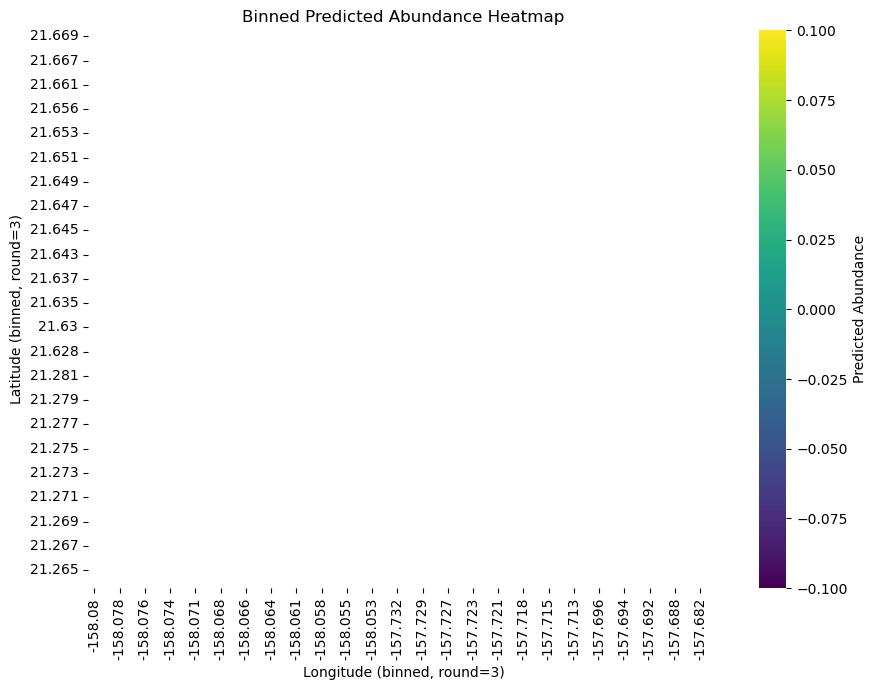

In [92]:
# Prepare prediction grid
pred_grid = sdd_df[['Latitude', 'Longitude', 'predicted_abundance']].dropna().copy()
if pred_grid.empty:
    raise RuntimeError("pred_grid is empty — check 'Latitude','Longitude','predicted_abundance' columns")

# Binned pivot heatmap (robust to duplicated coordinates)
lat_round = 3   # adjust for desired bin size
lon_round = 3
pred_grid['lat_bin'] = pred_grid['Latitude'].round(lat_round)
pred_grid['lon_bin'] = pred_grid['Longitude'].round(lon_round)

heatmap_df = pred_grid.pivot_table(
    index='lat_bin', columns='lon_bin', values='predicted_abundance', aggfunc='mean'
)

# Sort rows/columns for correct spatial orientation (largest lat at top -> small lat at bottom)
heatmap_df = heatmap_df.sort_index(ascending=False).sort_index(axis=1, ascending=True)

plt.figure(figsize=(9,7))
sns.heatmap(
    heatmap_df,
    cmap='viridis',
    cbar_kws={'label': 'Predicted Abundance'},
    linewidths=0.3,
    linecolor='white'
)
plt.title('Binned Predicted Abundance Heatmap')
plt.xlabel(f'Longitude (binned, round={lon_round})')
plt.ylabel(f'Latitude (binned, round={lat_round})')
plt.tight_layout()
plt.show()

RMSE: 12.710, R^2: -0.007, Mean Poisson Deviance: 9.028


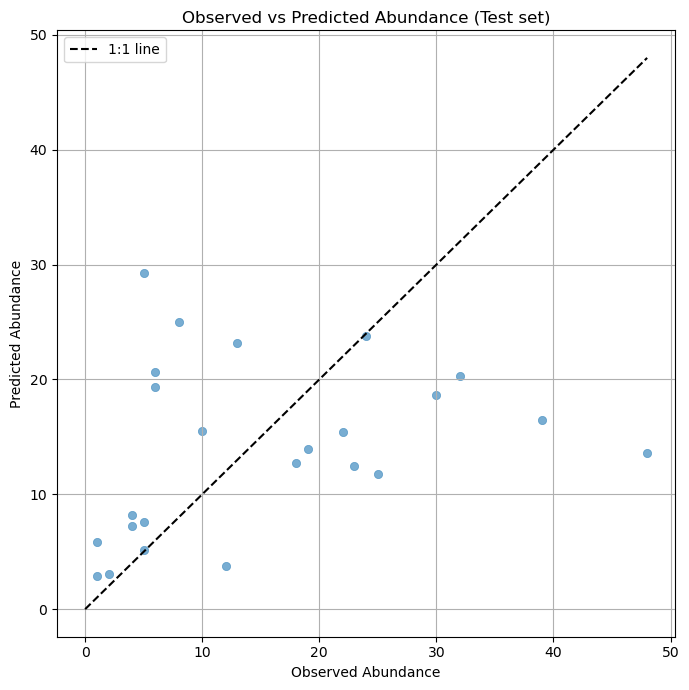

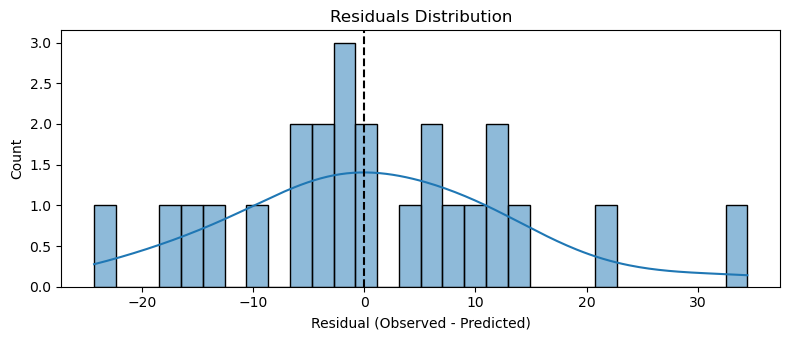

In [91]:
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance

# Observed and predicted (test set)
y_obs = Y_test.values if hasattr(Y_test, "values") else np.array(Y_test)

# Metrics
mse = mean_squared_error(y_obs, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_obs, y_test_pred)
mpd = mean_poisson_deviance(y_obs, y_test_pred)

print(f"RMSE: {rmse:.3f}, R^2: {r2:.3f}, Mean Poisson Deviance: {mpd:.3f}")

# Scatter plot observed vs predicted with 1:1 line
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_obs, y=y_pred, alpha=0.6, edgecolor=None)
max_val = max(y_obs.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], color='k', linestyle='--', label='1:1 line')
plt.xlabel('Observed Abundance')
plt.ylabel('Predicted Abundance')
plt.title('Observed vs Predicted Abundance (Test set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuals plot (observed - predicted)
residuals = y_obs - y_pred
plt.figure(figsize=(8,3.5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residual (Observed - Predicted)')
plt.title('Residuals Distribution')
plt.axvline(0, color='k', linestyle='--')
plt.tight_layout()
plt.show()
# ...existing code...